In [133]:
import pandas as pd, matplotlib.pyplot as plt, pylab as pl, seaborn as sbs
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *
from proj1_helpers import *

# Use clean data 
df = pd.read_csv("clean_train_data.csv")
y = df['Prediction'].values 
input_data = df.iloc[:,2:].values
ids = df.iloc[:,0].values

# Use subset of data
y = y[::50]
input_data = input_data[::50]
ids = ids[::50]

col_labels = df.columns
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,0.257671,0.532835,0.474611,-1.093454,-0.870648,-0.632428,0.987313,1.378045,...,-0.156564,-0.542982,-0.660444,-0.578666,1.234399,0.251795,-0.367844,0.612965,-1.359329,-0.645152
1,100005,-1,-0.544388,-0.706350,-0.475044,0.064383,0.115251,-0.233525,0.094923,-0.819132,...,1.229416,-0.370559,1.514133,-0.239608,-1.377788,-0.354529,-0.054320,0.115912,1.711823,0.094961
2,100006,1,0.426952,-0.208400,0.719034,-0.069451,-0.971751,-0.548472,0.276686,1.219260,...,-0.799385,-0.290304,-0.660444,0.236631,0.498040,0.807823,-0.032535,0.070414,-1.520013,-0.032292
3,100011,-1,-0.132873,-0.812497,-0.068375,-1.056294,0.073553,-0.313332,-0.144736,1.150840,...,1.180350,-0.315521,1.514133,-0.441676,-0.449036,0.173863,-0.032256,0.873721,-1.141415,-0.163737
4,100023,1,0.307234,-1.123065,0.812311,0.820835,-0.273740,-0.034514,-0.011685,-0.853987,...,-0.540272,0.858731,-0.660444,1.300559,0.665238,0.789031,0.762212,-0.384076,-1.529918,0.873721


In [134]:
N_FEATURES = input_data.shape[1]
N_DATA = len(input_data)
N_DATA

1363

In [135]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    x_te = x[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    x_tr = np.delete(x, k_indices[k], axis=0)
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    Phi_tr = build_poly(x_tr, degree)
    Phi_te = build_poly(x_te, degree)
    # form data with polynomial degree: TODO
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, Phi_tr, lambda_)
    # ridge regression: TODO
    # ***************************************************
    loss_te = compute_mse(y_te, Phi_te, w)
    # calculate the loss for train and test data: TODO
    # ***************************************************
    return loss_tr, loss_te, w

In [136]:
# Do a linear regression with two parameters for each feature
loss_vec = np.zeros(N_FEATURES)
loss_te_vec = np.zeros(N_FEATURES)
w_vec = np.zeros([N_FEATURES, 2])
k_fold = 4

# For each feature
for i in np.arange(N_FEATURES):
    x = input_data[:,i]
    lmse_te = 0
    lmse_tr = 0
    w = np.zeros(2)
    
    k_indices = build_k_indices(y, k_fold, 1)
    
    for k in range(k_fold):
        lmse_tr, lmse_te, w = cross_validation(y, x, k_indices, k, 0, 1)
        lmse_tr = lmse_tr + lmse_tr/k_fold
        lmse_te = lmse_te + lmse_te/k_fold
        w = w + w/4  
    tx = build_poly(x, 1)
    y_test = tx @ w
    y_test[y_test >= 0] = 1
    y_test[y_test < 0] = -1
    loss_te_vec[i] = (y - y_test) @ (y - y_test) 

In [137]:
loss_te_vec

array([2640., 2068., 2640., 2256., 1856., 1932., 1824., 2700., 2232.,
       2640., 2320., 2048., 1964., 2320., 2640., 2640., 2640., 2792.,
       2640., 2408., 2624., 2656., 2356., 2632., 2640., 2640., 2640.,
       2640., 2640., 2640.])

In [138]:
I = np.argmin(loss_te_vec)
print('Index', I, col_labels[I])

Index 6 DER_deltaeta_jet_jet


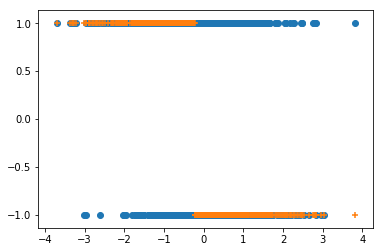

In [139]:
x = input_data[:,np.argmin(loss_te_vec)]

k_indices = build_k_indices(y, k_fold, 1)

for k in range(k_fold):
    lmse_tr, lmse_te, w = cross_validation(y, x, k_indices, k, .1, 1)
    lmse_tr = lmse_tr + lmse_tr/k_fold
    lmse_te = lmse_te + lmse_te/k_fold
    w = w + w/k_fold
    
tx = build_poly(x, 1)
    
y_test = tx @ w
y_test[y_test >= 0] = 1
y_test[y_test < 0] = -1

plt.scatter(x,y)
plt.scatter(x,y_test, marker='+')

In [140]:
w

array([-0.0700233 , -0.30752287])

In [141]:
queue = np.delete(np.arange(N_FEATURES), I)
x0 = input_data[:,I]
lossls0=loss_te_vec[I]

w_vec = np.zeros([N_FEATURES, 3])
loss_tr_vec = np.zeros(N_FEATURES)
loss_t_vec = np.zeros(N_FEATURES)


for i in queue: 
    x = np.array([x0, input_data[:, i]]).T
    print('Index ', i, ': single feature loss', loss_te_vec[i])
    lmse_te = 0
    lmse_tr = 0
    w = np.zeros(3)
    
    k_indices = build_k_indices(y, k_fold, 1)
    for k in range(k_fold):
        lmse_tr, lmse_te, w = cross_validation(y, x, k_indices, k, .1, 1)
        lmse_tr = lmse_tr + lmse_tr/k_fold
        lmse_te = lmse_te + lmse_te/k_fold
        w = w + w/k_fold
        
    tx = build_poly(x, 1)
    y_test = tx @ w
    y_test[y_test >= 0] = 1
    y_test[y_test < 0] = -1
    loss_t_vec[i] = (y - y_test) @ (y - y_test) 
    print('combined feature loss',i, loss_t_vec[i])
    


Index  0 : single feature loss 2640.0
combined feature loss 0 1816.0
Index  1 : single feature loss 2068.0
combined feature loss 1 1912.0
Index  2 : single feature loss 2640.0
combined feature loss 2 1824.0
Index  3 : single feature loss 2256.0
combined feature loss 3 1724.0
Index  4 : single feature loss 1856.0
combined feature loss 4 1832.0
Index  5 : single feature loss 1932.0
combined feature loss 5 1888.0
Index  7 : single feature loss 2700.0
combined feature loss 7 1812.0
Index  8 : single feature loss 2232.0
combined feature loss 8 1868.0
Index  9 : single feature loss 2640.0
combined feature loss 9 1824.0
Index  10 : single feature loss 2320.0
combined feature loss 10 1856.0
Index  11 : single feature loss 2048.0
combined feature loss 11 1928.0
Index  12 : single feature loss 1964.0
combined feature loss 12 1880.0
Index  13 : single feature loss 2320.0
combined feature loss 13 1808.0
Index  14 : single feature loss 2640.0
combined feature loss 14 1832.0
Index  15 : single featu

In [142]:
loss_t_vec[I]=np.inf
np.argmin(loss_t_vec)

3

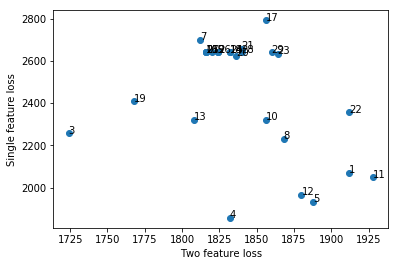

In [143]:
plt.scatter(np.delete(loss_t_vec,I),np.delete(loss_te_vec,I))
plt.xlabel('Two feature loss')
plt.ylabel('Single feature loss')
for i in np.arange(30):
    if i!=I:
        plt.annotate(i, (loss_t_vec[i], loss_te_vec[i]))
plt.savefig('Figures/2featureloss.png')



# Playing with polynomial degrees

In [56]:
features=np.array([1, 5, 8, 10, 11, 12, 13, 17, 22, 25])
features

array([ 1,  5,  8, 10, 11, 12, 13, 17, 22, 25])

In [144]:
x = input_data[:,features]
lmse_te = 0
lmse_tr = 0
w = np.zeros(2)
    
k_indices = build_k_indices(y, k_fold, 1)
    
for k in range(k_fold):
    lmse_tr, lmse_te, w = cross_validation(y, x, k_indices, k, 0, 1)
    lmse_tr = lmse_tr + lmse_tr/k_fold
    lmse_te = lmse_te + lmse_te/k_fold
    w = w + w/4  
tx = build_poly(x, 1)
y_test = tx @ w
y_test[y_test >= 0] = 1
y_test[y_test < 0] = -1

In [146]:
np.save('weights.npy',w)